In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
import numpy as np
import scipy

import influence.logistic_regression
import experiments
import experiments.counterexamples
from experiments.plot import *

from datasets.common import DataSet


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [96]:
config = { 'seed': 0, 'dataset_id': 'gauss2' }
E = experiments.counterexamples.Counterexamples(config)
E.run(invalidate_phase=3)

Experiment counterexamples: running gauss2
Results will be stored in /home/bbbert/influence/output/counterexamples/gauss2

Loading phase 0-generate_datasets from previous run:
/home/bbbert/influence/output/counterexamples/gauss2/result_0-generate_datasets.npz

Loading phase 1-training from previous run:
/home/bbbert/influence/output/counterexamples/gauss2/result_1-training.npz

Loading phase 2-find_newton_lt_pred from previous run:
/home/bbbert/influence/output/counterexamples/gauss2/result_2-find_newton_lt_pred.npz

Running phase 3-find_test_distribution...
INFO:tensorflow:Restoring parameters from /home/bbbert/influence/output/counterexamples/gauss2/models/initial
Gradients computed: 1000/1000
Margin gradients computed: 1000/1000
Computing first-order influence...
Computing first-order influence took 0.000175952911377 seconds.
Computing Newton influence...
Computing Newton influence took 0.000217914581299 seconds.
Computing actual influence...
INFO:tensorflow:Restoring parameters fro

In [93]:
E = experiments.counterexamples.Counterexamples.load_run('gauss2')

Loading phase 0-generate_datasets from previous run:
/home/bbbert/influence/output/counterexamples/gauss2/result_0-generate_datasets.npz
Loading phase 1-training from previous run:
/home/bbbert/influence/output/counterexamples/gauss2/result_1-training.npz
Loading phase 2-find_newton_lt_pred from previous run:
/home/bbbert/influence/output/counterexamples/gauss2/result_2-find_newton_lt_pred.npz
Loading phase 3-find_test_distribution from previous run:
/home/bbbert/influence/output/counterexamples/gauss2/result_3-find_test_distribution.npz
Experiment counterexamples: run gauss2 results loaded in 0.0140800476074 seconds.



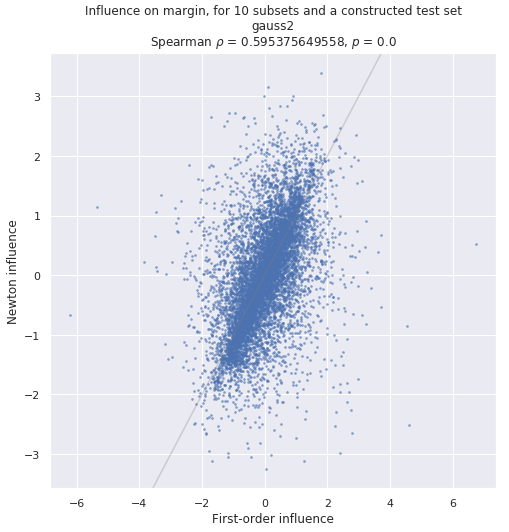

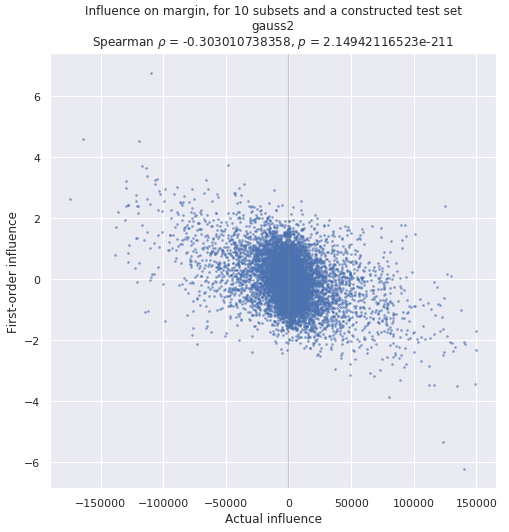

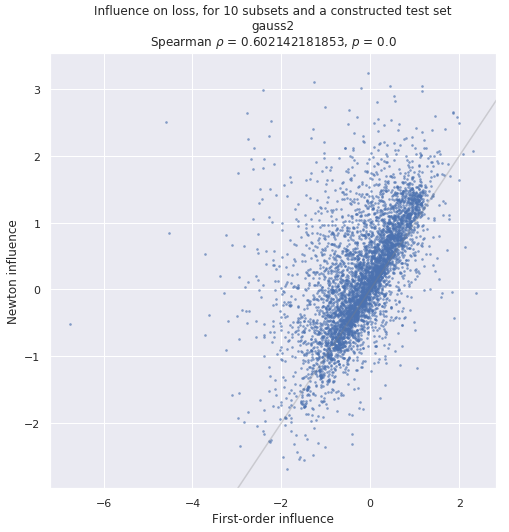

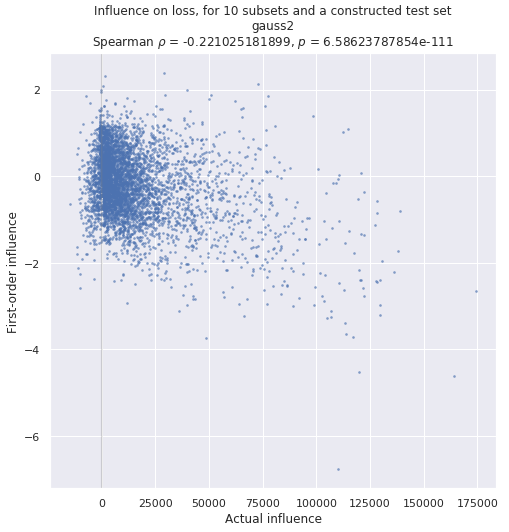

In [97]:
E.plot_dist_infl(False)

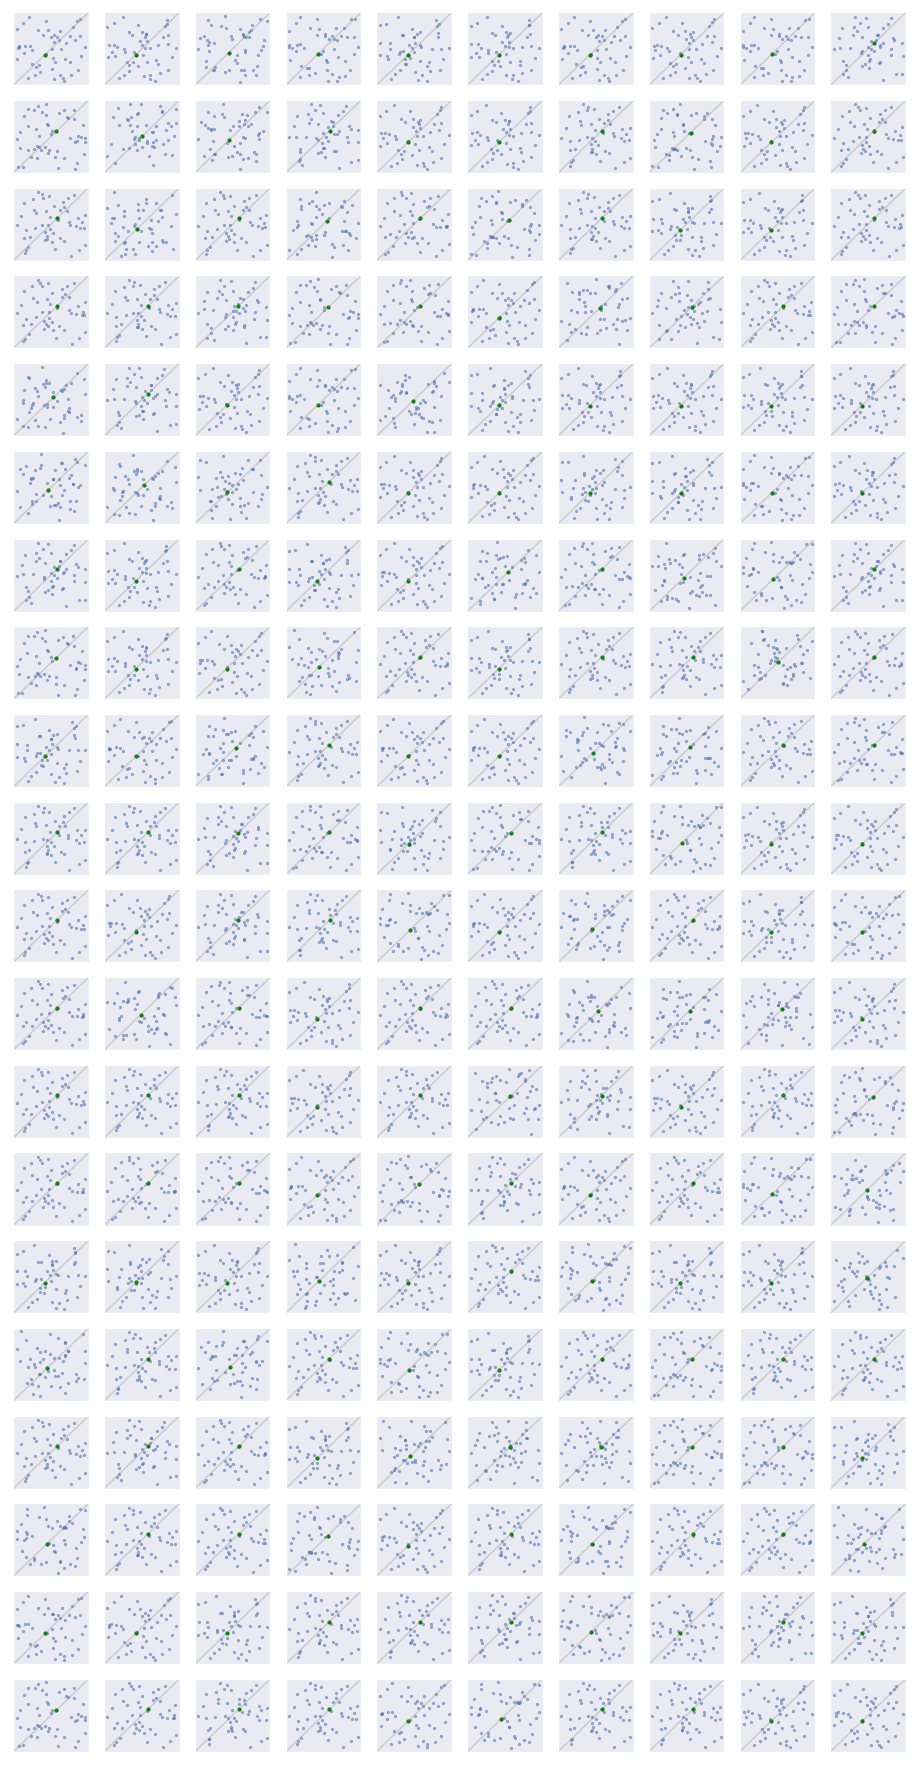

In [92]:
pred = E.R['dist_subset_pred_margin_infl']
newton = E.R['dist_subset_newton_pred_margin_infl']
actl = E.R['dist_subset_actl_margin_infl']
C = 10
R = (pred.shape[1] + C - 1) // C
R = min(R, 20)
fig, ax = plt.subplots(R, C, figsize=(16, 16 * R / 10))
for i in range(R):
    for j in range(C):
        id = i * C + j
        if id < pred.shape[1]:
            plot_influence_correlation(ax[i][j], actl[:, id].reshape(-1), pred[:, id].reshape(-1),
                                      title='',xlabel='',ylabel='',spearmanr=False)
            ax[i][j].get_xaxis().set_ticks([])
            ax[i][j].get_yaxis().set_ticks([])
            ax[i][j].scatter(0, 0, s=10, color='green')